# Projet 4 :
# Anticipez les besoins en consommation de bâtiments


## III) Modélisation:
## Les émissions de gaz à effet de serre 'TotalGHGEmissions'
On va tenter de prédire les d'émissions de gaz à effet de serre 'TotalGHGEmissions' de bâtiments non destinés à l’habitation, pour lesquels elles n’ont pas encore été mesurées.



### chargement des bibilothèques

In [1]:
# Importation des bibliothèques et modules nécessaires

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy
import sklearn.preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder

from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import RandomizedSearchCV
import random
import time
from sklearn.metrics import make_scorer
# installer xgboost
!pip install xgboost
from xgboost import XGBRegressor

# installer category-encoders
!pip install category-encoders

# installer shap
!pip install shap
import shap

In [2]:
# Chargement du jeu de données df
df = pd.read_csv('df.csv', sep=',')

In [3]:
# Afficher les 5 premières lignes du jeu de données df

df.head()

,BuildingType,YearBuilt,NumberofBuildings,NumberofFloors,LargestPropertyUseType,ENERGYSTARScore,SteamUse(kBtu),NaturalGas(kBtu),TotalGHGEmissions,SiteEnergyUse(kBtu),PropertyGFATotal,PropertyGFAParking
0,0.0,1920,1.0,12,tourism,60.0,1.0,1.0,5.525373,15.793246,11.390023,0.000000
1,0.0,1990,1.0,11,tourism,61.0,0.0,1.0,5.693261,15.942305,11.547974,9.620129
2,0.0,1960,1.0,41,tourism,43.0,1.0,1.0,7.645053,18.100297,13.770629,12.189532
3,0.0,1920,1.0,10,tourism,56.0,1.0,1.0,5.660979,15.731637,11.023878,0.000000
4,0.0,1980,1.0,18,tourism,75.0,0.0,1.0,6.226556,16.466822,12.075856,11.034906


 ### Target 'TotalGHGEmissions'

In [4]:
# définir la liste des variables cibles
Target = ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']

In [5]:
# examiner la colonne catégorielle 'LargestPropertyUseType'
df['LargestPropertyUseType'].value_counts(dropna=False)

Office                                             485
Non-Refrigerated Warehouse                         197
tourism                                            117
Other                                              104
Retail Store                                        94
Education                                           85
Worship Facility                                    69
public health                                       59
Distribution Center                                 54
Supermarket/Grocery Store                           41
Other - Recreation                                  31
Parking                                             30
Self-Storage Facility                               28
Public Services                                     28
Senior Care Community                               20
Restaurant                                          14
Laboratory                                          13
Refrigerated Warehouse                              12
Social/Mee

In [6]:
# Le nombre minimum de groupe pour chaque classe ne peut pas être inférieur à 2 
# On va placer 'Small- and Mid-Sized Office' (valeur unique) dans le groupe 'Office'
df.loc[df['LargestPropertyUseType'] == 'Small- and Mid-Sized Office', 'LargestPropertyUseType'] = 'Office'
df['LargestPropertyUseType'].value_counts(dropna=False)

Office                                             486
Non-Refrigerated Warehouse                         197
tourism                                            117
Other                                              104
Retail Store                                        94
Education                                           85
Worship Facility                                    69
public health                                       59
Distribution Center                                 54
Supermarket/Grocery Store                           41
Other - Recreation                                  31
Parking                                             30
Self-Storage Facility                               28
Public Services                                     28
Senior Care Community                               20
Restaurant                                          14
Laboratory                                          13
Refrigerated Warehouse                              12
Social/Mee

### LinearRegression

Avant de commencer à entraîner des modèles plus avancés, on va vérifier la performance minimale avec une régression linéaire classique (baseline). 

Nous commencerons par diviser les données en ensembles d'entraînement et de test, en stratifiant selon 'LargestPropertyUseType'. Ensuite, nous appliquerons l'encodage TargetEncoder() à la colonne catégorielle 'LargestPropertyUseType' et concaténerons les colonnes préparées. Nous définirons ensuite le modèle de régression linéaire et l'entraînerons sur les données d'entraînement préparées. Enfin, le modèle sera utilisé pour effectuer des prédictions sur les données de test pré-traitées.

In [7]:
# définir les variables X et la variable cible y
X = df.drop(columns=Target)
y = df['TotalGHGEmissions']

# Créer une liste de variables catégorielles et une liste de de variables numériques
variables_catégorielles = X.select_dtypes(include=['O']).columns.tolist()
variables_numériques = X.select_dtypes(exclude=['O']).columns.tolist()

# Diviser les données en ensembles d'entraînement et de test en stratifiant par 'LargestPropertyUseType'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=X['LargestPropertyUseType'], random_state=0)

# Encodage de la variable catégorielle après le "train_test_split"
Target_Encoder = TargetEncoder()
X_train_encoded = Target_Encoder.fit_transform(X_train[variables_catégorielles], y_train)
X_test_encoded = Target_Encoder.transform(X_test[variables_catégorielles])

# Concaténation des colonnes prétraitées
X_train_numérique = X_train[variables_numériques]
X_train_concat = pd.concat([X_train_numérique, X_train_encoded], axis=1)
X_test_numérique = X_test[variables_numériques]
X_test_concat = pd.concat([X_test_numérique, X_test_encoded], axis=1)

# Créer le modèle de régression linéaire
Linear_Regression = LinearRegression()

# enregistrer le temps de début 
start_time = time.time() 
    
# Entraîner le modèle sur les données d'entraînement
Linear_Regression.fit(X_train_concat, y_train)

# Prédictions
y_pred = Linear_Regression.predict(X_test_concat)

# calculer le temps d'entraînement
training_time = time.time() - start_time 

# baseline_error
baseline_error = np.mean((Linear_Regression.predict(X_test_concat) - y_test) ** 2)

# Évaluation
print("MAE = {:.2f}".format(mean_absolute_error(y_test, y_pred)))
print("MSE =", mean_squared_error(y_test, y_pred))
print("RMSE = {:.2f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
print("R² = {:.2f}".format(r2_score(y_test, y_pred)))
print("training_time =", training_time)
print("baseline_error =", baseline_error)

MAE = 0.57
MSE = 0.5326929198948916
RMSE = 0.73
R² = 0.72
training_time = 0.009753942489624023
baseline_error = 0.5326929198948919


In [8]:
# Appliquer la transformation inverse à y_test et y_pred
y_test_unité_origine = np.exp(y_test) - 1
y_pred_unité_origine = np.exp(y_pred) - 1

# Évaluation
print('*'*33)
print("RMSE dans l'unité de base (tCO2e)")
print('*'*33)
print("RMSE = {:.2f}".format(np.sqrt(mean_squared_error(y_test_unité_origine, y_pred_unité_origine))))
print('*'*33)

*********************************
RMSE dans l'unité de base (tCO2e)
*********************************
RMSE = 357.41
*********************************


In [9]:
# Obtenir les coefficients de régression linéaire
importance_variables = Linear_Regression.coef_

# Imprimer les scores d'importance de chaque variable indépendante
for i,v in enumerate(importance_variables):
    print('Feature: %s, Score: %.5f' % (X.columns[i], v))    

Feature: BuildingType, Score: 0.86522
Feature: YearBuilt, Score: 0.00045
Feature: NumberofBuildings, Score: 0.00058
Feature: NumberofFloors, Score: -0.00145
Feature: LargestPropertyUseType, Score: -0.01167
Feature: ENERGYSTARScore, Score: 0.97777
Feature: SteamUse(kBtu), Score: 1.30423
Feature: NaturalGas(kBtu), Score: 0.85808
Feature: PropertyGFATotal, Score: -0.02428
Feature: PropertyGFAParking, Score: 0.72481


In [10]:
# Afficher les 5 premières lignes de X_train_preprocessed
X_train_concat.head()

,BuildingType,YearBuilt,NumberofBuildings,NumberofFloors,ENERGYSTARScore,SteamUse(kBtu),NaturalGas(kBtu),PropertyGFATotal,PropertyGFAParking,LargestPropertyUseType
73,0.0,1960,2.0,4,53.0,0.0,1.0,10.820138,0.0,4.921626
1504,0.0,1920,1.0,3,70.0,1.0,1.0,12.967691,0.0,4.346185
372,0.0,1980,1.0,1,14.0,0.0,1.0,10.828104,0.0,3.105016
1247,0.0,1900,1.0,4,70.0,0.0,1.0,10.413343,0.0,3.924187
620,0.0,1900,1.0,5,24.0,0.0,0.0,10.197686,0.0,3.924187


In [11]:
# Nombre de lignes et colonnes (taille de X_train_preprocessed)

print(f"Nombre de (lignes, colonnes) = {X_train_concat.shape}")

Nombre de (lignes, colonnes) = (1238, 10)


In [12]:
# Afficher les 5 premières lignes de X_test_preprocessed

X_test_concat.head()

,BuildingType,YearBuilt,NumberofBuildings,NumberofFloors,ENERGYSTARScore,SteamUse(kBtu),NaturalGas(kBtu),PropertyGFATotal,PropertyGFAParking,LargestPropertyUseType
339,0.0,1960,1.0,1,96.0,0.0,1.0,10.882772,0.0,3.924187
1250,0.0,1930,1.0,1,27.0,0.0,0.0,10.045464,0.0,3.105016
357,0.0,1930,1.0,14,66.0,0.0,1.0,12.624957,0.0,3.924187
15,0.0,1930,1.0,6,70.0,1.0,1.0,11.551300,0.0,4.133317
135,0.0,1920,1.0,2,98.0,0.0,1.0,10.926909,0.0,4.346185


In [13]:
# Nombre de lignes et colonnes (taille de X_train_preprocessed)

print(f"Nombre de (lignes, colonnes) = {X_test_concat.shape}")

Nombre de (lignes, colonnes) = (310, 10)


#### fonctions

https://scikit-learn.org/0.18/auto_examples/model_selection/plot_learning_curve.html

In [14]:

 # Définir une fonction pour tracer la courbe d'apprentissage
    
from sklearn.model_selection import learning_curve

def courbe_apprentissage(estimator, X, y, cv=None, train_sizes=np.linspace(.1, 1.0, 5), 
                        scoring=None, n_jobs=None, title=None):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring=scoring, n_jobs=n_jobs)
    
    # Calcul de la moyenne et de l'écart-type des scores d'apprentissage et de test
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Trace la courbe d'apprentissage
    sns.set_theme()
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, 
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="train")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="validation")
    plt.xlabel("Taille de l'ensemble d'apprentissage")
    plt.ylabel("Score")
    plt.legend(loc="best")
    if title:
        plt.title(title)
    sns.set_theme()
    plt.show()

In [15]:
# fonction pour visualiser la performance du modèle : Valeurs cibles vs Prédictions
def scatter_algo(algo, X, y, title=None):
    sns.set_theme()
    # Calculer les prédictions y_pred pour les exemples X
    y_pred = algo.predict(X)
    plt.scatter(y, y, color='r', alpha=1, label='Valeurs cibles')
    plt.scatter(y, y_pred, color='blue', alpha=1, label='Prédictions')
    if title:
        plt.title(title)
     # Ajouter une légende
    plt.legend(loc='upper left')
    
    # Afficher le graphique
    plt.show()

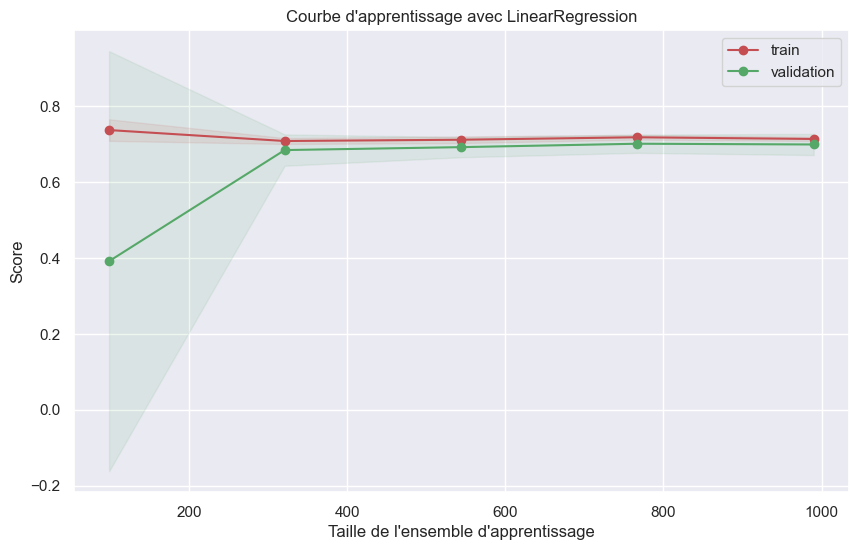

In [16]:
courbe_apprentissage(Linear_Regression, X_train_concat, y_train, title="Courbe d'apprentissage avec LinearRegression")

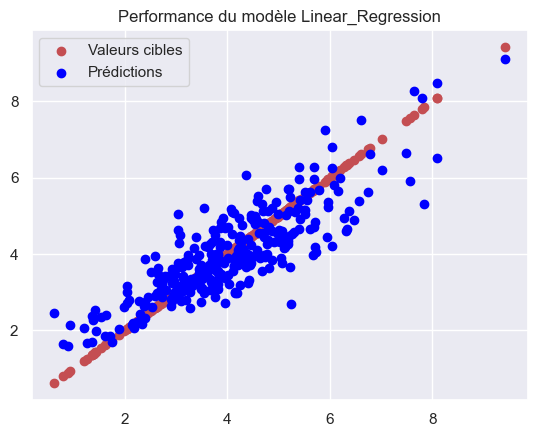

In [17]:
scatter_algo(Linear_Regression, X_test_concat, y_test, title="Performance du modèle Linear_Regression")

### Évaluation des algorithmes

On va évaluer puis comparer ces algorithmes afin de choisir le bon modèle:

- RidgeCV
- LassoCV
- ElasticNetCV
- RandomForestRegressor
- XGBRegressor


## RidgeCV


Meilleur alpha trouvé pour RidgeCV : 1.8896523396912077
MAE = 0.57
MSE = 0.53
RMSE = 0.73
R² = 0.72


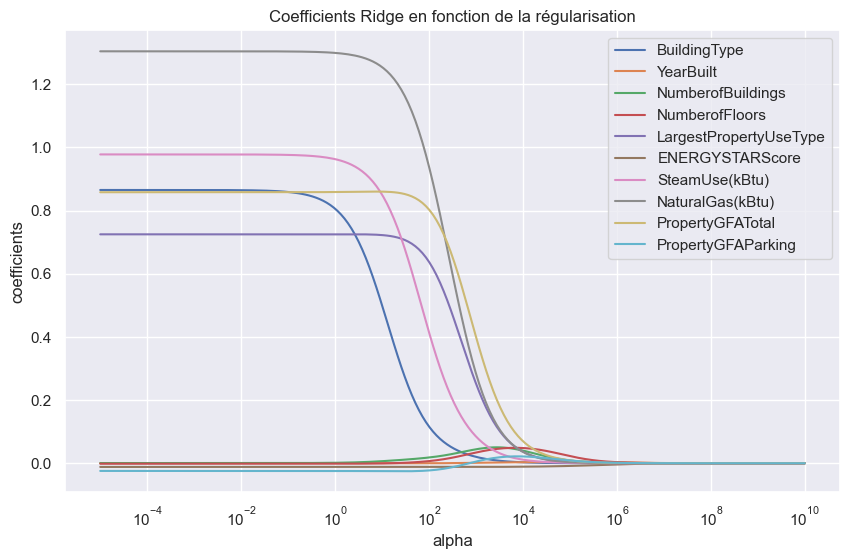

In [18]:
# Définir alpha

alphas = np.logspace(-5, 10, 200)

# Créer un pipeline qui applique TargetEncoder et RidgeCV

Ridge_pipe = make_pipeline(
    TargetEncoder(), 
    RidgeCV(alphas=alphas, cv=KFold(n_splits=3, shuffle=True, random_state=0)))

# Entraîner le modèle avec le pipeline

Ridge_pipe.fit(X_train, y_train)

# Prédire les valeurs sur l'ensemble de test

y_pred = Ridge_pipe.predict(X_test)

# Afficher le meilleur alpha pour RidgeCV
print("Meilleur alpha trouvé pour RidgeCV :", Ridge_pipe.named_steps['ridgecv'].alpha_)

# Évaluation
print("MAE = {:.2f}".format(mean_absolute_error(y_test, y_pred)))
print("MSE = {:.2f}".format(mean_squared_error(y_test, y_pred)))
print("RMSE = {:.2f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
print("R² = {:.2f}".format(r2_score(y_test, y_pred)))

# Stocker les coefficients pour différentes valeurs d'alpha
coef_list = []
for alpha in alphas:
    ridge = RidgeCV(alphas=[alpha], cv=KFold(n_splits=3, shuffle=True, random_state=0))
    ridge.fit(Ridge_pipe.named_steps['targetencoder'].transform(X_train), y_train) 
    coef_list.append(ridge.coef_)

# Tracer les coefficients pour différentes valeurs d'alpha
coef_array = np.array(coef_list)
sns.set_theme()
plt.figure(figsize=(10, 6))
plt.plot(alphas, coef_array, label=X.columns)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.title("Coefficients Ridge en fonction de la régularisation")
plt.legend()
plt.show()


Plus le coefficient alpha est élevé, plus la régularisation est forte et plus les coefficients sont poussés vers zéro. À l'inverse, un coefficient alpha proche de zéro permet aux coefficients de prendre des valeurs plus grandes, ce qui peut conduire à un surapprentissage (overfitting).

In [19]:
# Appliquer la transformation inverse à y_test et y_pred
y_test_unité_origine = np.exp(y_test) - 1
y_pred_unité_origine = np.exp(y_pred) - 1

# Évaluation
print('*'*33)
print("RMSE dans l'unité de base (tCO2e)")
print('*'*33)
print("RMSE = {:.2f}".format(np.sqrt(mean_squared_error(y_test_unité_origine, y_pred_unité_origine))))
print('*'*33)

*********************************
RMSE dans l'unité de base (tCO2e)
*********************************
RMSE = 351.29
*********************************


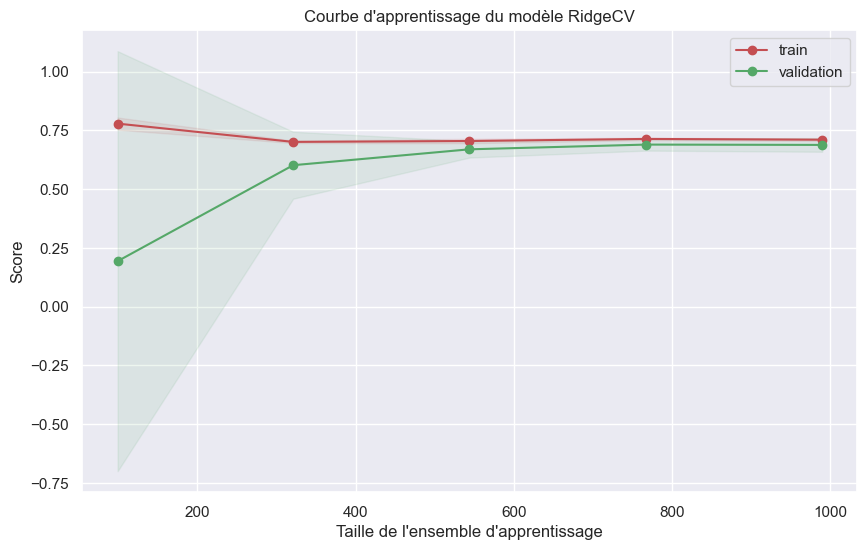

In [20]:
courbe_apprentissage(Ridge_pipe, X_train, y_train, title="Courbe d'apprentissage du modèle RidgeCV")

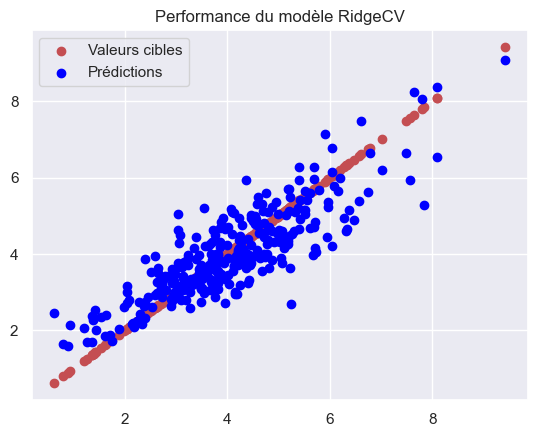

In [21]:
scatter_algo(Ridge_pipe, X_test, y_test, title="Performance du modèle RidgeCV")

invalid value encountered in reciprocal
invalid value encountered in reciprocal
invalid value encountered in reciprocal
invalid value encountered in reciprocal
invalid value encountered in reciprocal
invalid value encountered in reciprocal
invalid value encountered in reciprocal
invalid value encountered in reciprocal
invalid value encountered in reciprocal
invalid value encountered in reciprocal
invalid value encountered in reciprocal
invalid value encountered in reciprocal
invalid value encountered in reciprocal
invalid value encountered in reciprocal
invalid value encountered in reciprocal
invalid value encountered in reciprocal
invalid value encountered in reciprocal
invalid value encountered in reciprocal
invalid value encountered in reciprocal
invalid value encountered in reciprocal
invalid value encountered in reciprocal
invalid value encountered in reciprocal
invalid value encountered in reciprocal
invalid value encountered in reciprocal
invalid value encountered in reciprocal


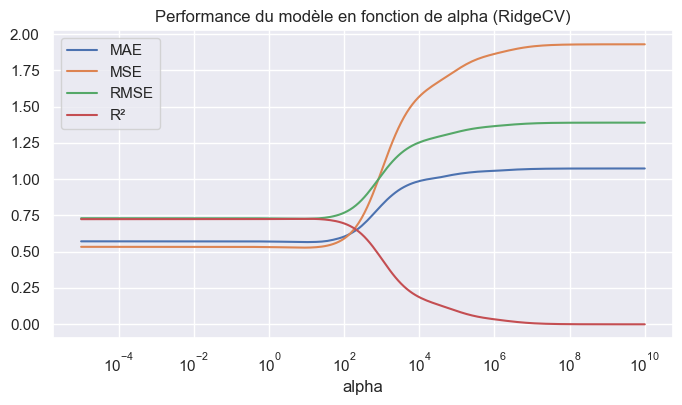

In [22]:
# Initialiser les listes pour stocker les résultats
mae_list = []
rmse_list = []
r2_list = []
mse_list = []

for alpha in alphas:
    # Initialiser le modèle RidgeCV avec alphas donné
    ridge = RidgeCV(alphas=[alpha])

    # Entraîner le modèle sur les données d'entraînement
    ridge.fit(Ridge_pipe.named_steps['targetencoder'].transform(X_train), y_train)

    # Prédire sur les données de validation
    y_pred = ridge.predict(Ridge_pipe.named_steps['targetencoder'].transform(X_test))

    # Calculer l'AME, RMSE et R_2 pour les prédictions
    mae = np.mean(np.abs(y_test - y_pred))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    # Ajouter les résultats aux listes correspondantes
    mae_list.append(mae)
    rmse_list.append(rmse)
    r2_list.append(r2)
    mse_list.append(mse)
    
# Tracer les résultats pour différentes valeurs d'alpha
sns.set_theme()
plt.figure(figsize=(8, 4))
plt.plot(alphas, mae_list, label='MAE')
plt.plot(alphas, mse_list, label='MSE')
plt.plot(alphas, rmse_list, label='RMSE')
plt.plot(alphas, r2_list, label='R²')
plt.xscale('log')
plt.xlabel('alpha')
plt.title("Performance du modèle en fonction de alpha (RidgeCV)")
plt.legend()
plt.show()


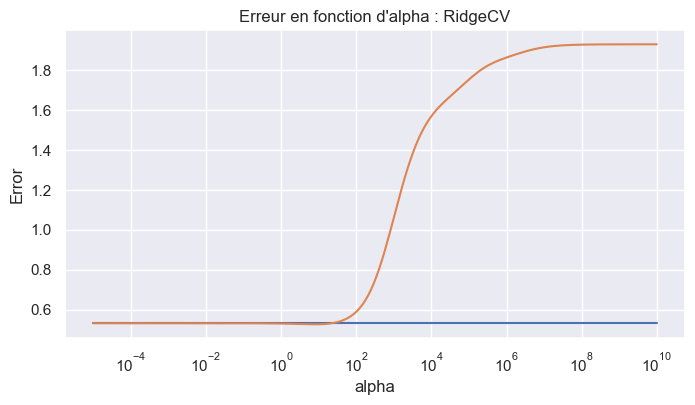

In [23]:
# Erreur en fonction d'alpha
errors = []
for alpha in alphas:
    Ridge_pipe.set_params(ridgecv__alphas=[alpha])
    Ridge_pipe.fit(X_train, y_train)
    y_pred = Ridge_pipe.predict(X_test)
    errors.append([baseline_error, np.mean((Ridge_pipe.predict(X_test) - y_test) ** 2)])

# Tracer les résultats pour différentes valeurs d'alpha
sns.set_theme()
plt.figure(figsize=(8, 4))
plt.plot(alphas, errors)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Error')
plt.title("Erreur en fonction d'alpha : RidgeCV")
plt.show()


In [24]:
min(errors)

[0.5326929198948919, 0.5271349030660062]

In [25]:
max(errors)

[0.5326929198948919, 1.9288917271491708]

## LassoCV


Meilleur alpha trouvé pour Lasso : 0.0004229242874389499
MAE = 0.57
MSE = 0.53
RMSE = 0.73
R² = 0.72


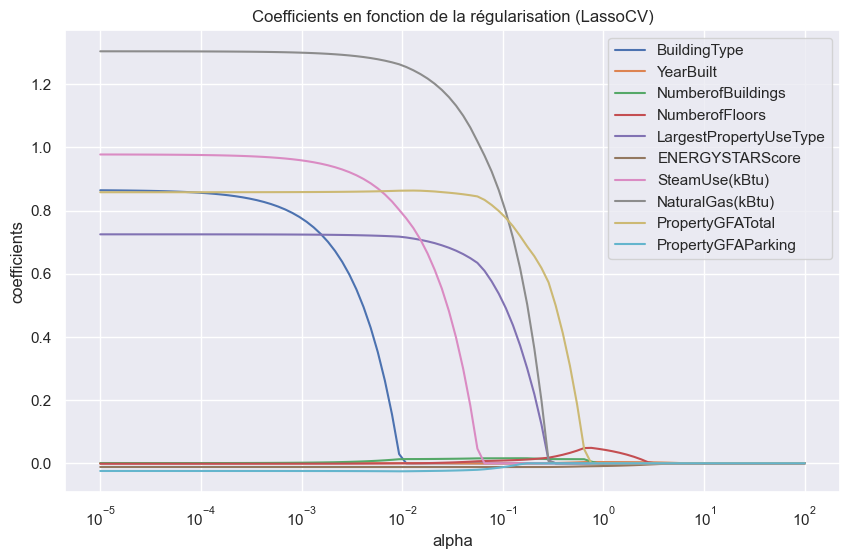

In [26]:
# Définir les valeurs pour la régularisation alpha
alphas = np.logspace(-5, 2, 100)

# Créer un pipeline qui applique TargetEncoder et LassoCV
Lasso_pipe = make_pipeline(
    TargetEncoder(), # Ajouter TargetEncoder avant LassoCV
    LassoCV(alphas=alphas, cv=KFold(n_splits=3, shuffle=True, random_state=0))
)

# Entraîner le modèle avec le pipeline
Lasso_pipe.fit(X_train, y_train)

# Prédire les valeurs sur l'ensemble de test
y_pred = Lasso_pipe.predict(X_test)

# Afficher le meilleur alpha pour LassoCV
print("Meilleur alpha trouvé pour Lasso :", Lasso_pipe.named_steps['lassocv'].alpha_)


# Évaluation
print("MAE = {:.2f}".format(mean_absolute_error(y_test, y_pred)))
print("MSE = {:.2f}".format(mean_squared_error(y_test, y_pred)))
print("RMSE = {:.2f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
print("R² = {:.2f}".format(r2_score(y_test, y_pred)))

# Stocker les coefficients pour différentes valeurs d'alpha
coef_list = []
for alpha in alphas:
    lasso = LassoCV(alphas=[alpha], cv=KFold(n_splits=3, shuffle=True, random_state=0))
    lasso.fit(Lasso_pipe.named_steps['targetencoder'].transform(X_train), y_train)
    coef_list.append(lasso.coef_)

# Tracer les coefficients pour différentes valeurs d'alpha
coef_array = np.array(coef_list)
sns.set_theme()
plt.figure(figsize=(10, 6))
plt.plot(alphas, coef_array, label=X.columns)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.title("Coefficients en fonction de la régularisation (LassoCV)")
plt.legend()
plt.show()


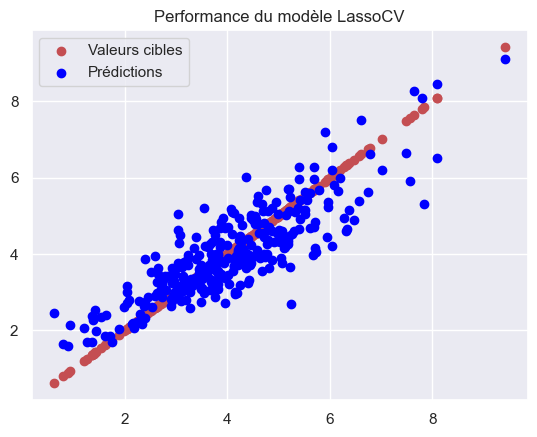

In [27]:
scatter_algo(Lasso_pipe, X_test, y_test, title="Performance du modèle LassoCV")

Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.683625186856986, tolerance: 0.04837121108614448
Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.130276520508488, tolerance: 0.04837121108614448
Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.917390495996045, tolerance: 0.04837121108614448
Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.389905540348593, tolerance: 0.04837121108614448
Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.517845254788725, tolerance: 0.04837121108614448
Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.55213881641845, tolerance: 0.04837121108614448


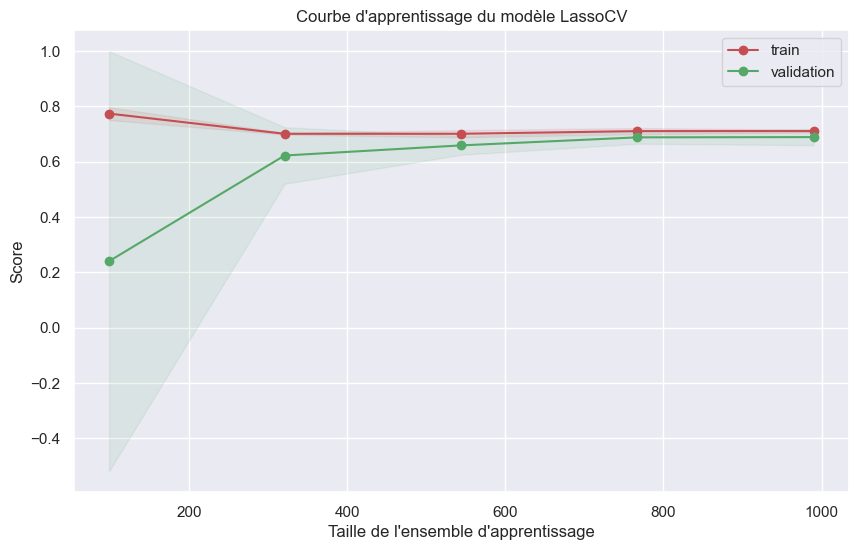

In [28]:
courbe_apprentissage(Lasso_pipe, X_train, y_train, title="Courbe d'apprentissage du modèle LassoCV")

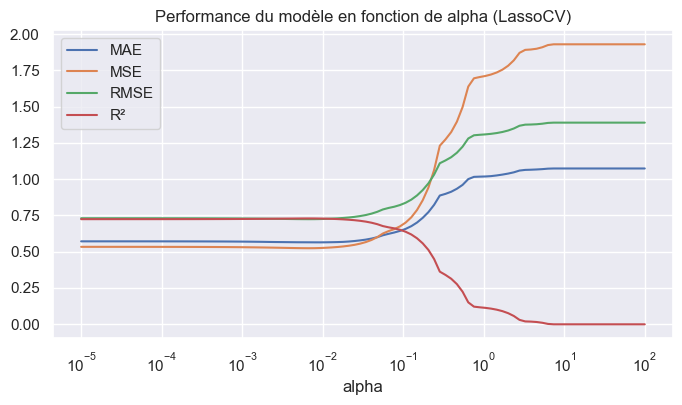

In [29]:
# Initialiser les listes pour stocker les résultats
mae_list = []
rmse_list = []
r2_list = []
mse_list = []

for alpha in alphas:
    # Initialiser le modèle LassoCV avec alphas donné
    lasso = LassoCV(alphas=[alpha])

    # Entraîner le modèle sur les données d'entraînement
    lasso.fit(Lasso_pipe.named_steps['targetencoder'].transform(X_train), y_train)

    # Prédire sur les données de validation
    y_pred = lasso.predict(Lasso_pipe.named_steps['targetencoder'].transform(X_test))
    
    mae_list.append(np.mean(np.abs(y_test - y_pred)))
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2_list.append(r2_score(y_test, y_pred))
    mse_list.append(mean_squared_error(y_test, y_pred))
    
# Tracer les résultats pour différentes valeurs d'alpha
sns.set_theme()
plt.figure(figsize=(8, 4))
plt.plot(alphas, mae_list, label='MAE')
plt.plot(alphas, mse_list, label='MSE')
plt.plot(alphas, rmse_list, label='RMSE')
plt.plot(alphas, r2_list, label='R²')
plt.xscale('log')
plt.xlabel('alpha')
plt.title("Performance du modèle en fonction de alpha (LassoCV)")
plt.legend()
plt.show()


In [30]:
# Appliquer la transformation inverse à y_test et y_pred
y_test_unité_origine = np.exp(y_test) - 1
y_pred_unité_origine = np.exp(y_pred) - 1

# Évaluation
print('*'*33)
print("RMSE dans l'unité de base (tCO2e)")
print('*'*33)
print("RMSE = {:.2f}".format(np.sqrt(mean_squared_error(y_test_unité_origine, y_pred_unité_origine))))
print('*'*33)

*********************************
RMSE dans l'unité de base (tCO2e)
*********************************
RMSE = 805.11
*********************************


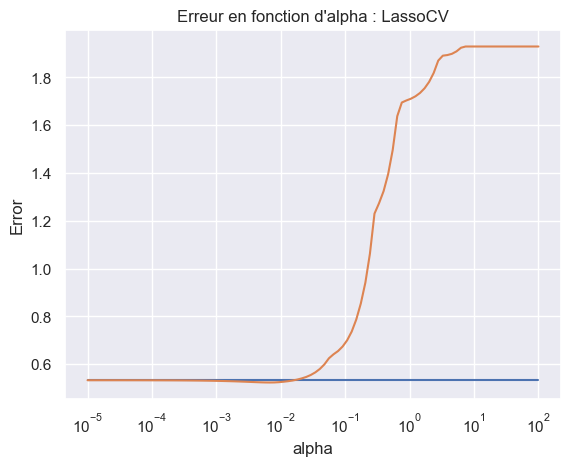

In [31]:
# Erreur en fonction d'alpha
errors = []
for alpha in alphas:
    Lasso_pipe.set_params(lassocv__alphas=[alpha])
    Lasso_pipe.fit(X_train, y_train)
    y_pred = Lasso_pipe.predict(X_test)
    errors.append([baseline_error, np.mean((Lasso_pipe.predict(X_test) - y_test) ** 2)])

# Tracer les résultats pour différentes valeurs d'alpha
sns.set_theme()
plt.plot(alphas, errors)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Error')
plt.title("Erreur en fonction d'alpha : LassoCV")
plt.show()

In [32]:
min(errors)

[0.5326929198948919, 0.5231622466445687]

In [33]:
max(errors)

[0.5326929198948919, 1.9289092769627818]

## ElasticNetCV

In [34]:
# Définir les valeurs alpha et la pénalisation L1/L2
alphas = np.logspace(-5, 2, 100)

# Créer un pipeline qui applique TargetEncoder et ElasticNetCV
ElasticNet_pipe = make_pipeline(
    TargetEncoder(),
    ElasticNetCV(alphas=alphas, cv=KFold(n_splits=3, shuffle=True, random_state=0))
)

# Entraîner le modèle avec le pipeline
ElasticNet_pipe.fit(X_train, y_train)

# Prédire les valeurs sur l'ensemble de test
y_pred = ElasticNet_pipe.predict(X_test)

# Évaluation
print("MAE : {:.2f}".format(mean_absolute_error(y_test, y_pred)))
print("MSE : {:.2f}".format(mean_squared_error(y_test, y_pred)))
print("RMSE : {:.2f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
print("R² : {:.2f}".format(r2_score(y_test, y_pred)))
print("Meilleur alpha trouvé :", ElasticNet_pipe.named_steps['elasticnetcv'].alpha_)
print("Meilleur paramètre l1_ratio : %.5f" % ElasticNet_pipe.named_steps['elasticnetcv'].l1_ratio_)


MAE : 0.57
MSE : 0.53
RMSE : 0.73
R² : 0.72
Meilleur alpha trouvé : 0.0011233240329780276
Meilleur paramètre l1_ratio : 0.50000


Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06670919930459718, tolerance: 0.04837121108614448
Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.542353751343597, tolerance: 0.04837121108614448
Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.128476041655972, tolerance: 0.04681212447164635
Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.497082262424243, tolerance: 0.04681212447164635
Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.607463445305399, tolerance: 0.04681212447164635
Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.023527989034392, tolerance: 0.04681212447164635
Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.128476041655972, tolerance: 0.046812

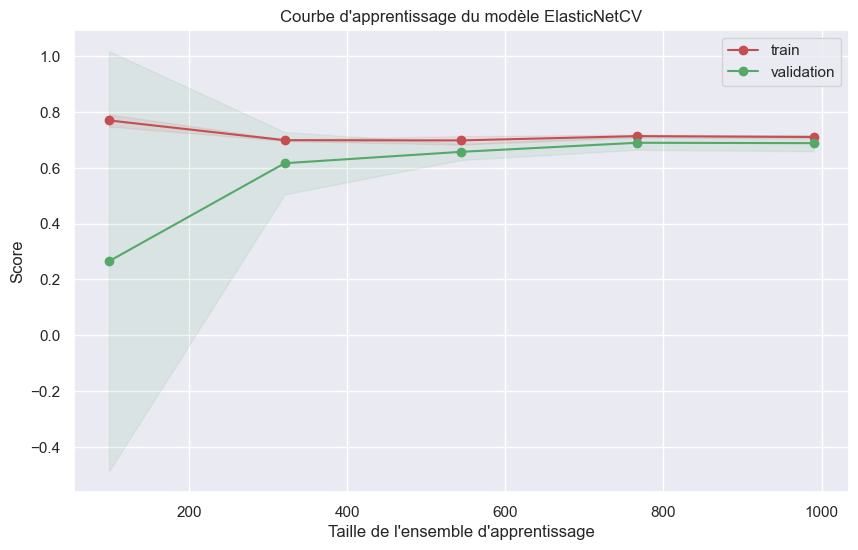

In [35]:
courbe_apprentissage(ElasticNet_pipe, X_train, y_train, title="Courbe d'apprentissage du modèle ElasticNetCV")

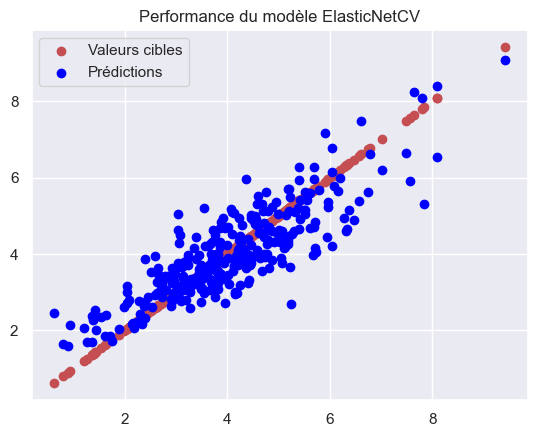

In [36]:
scatter_algo(ElasticNet_pipe, X_test, y_test, title="Performance du modèle ElasticNetCV")

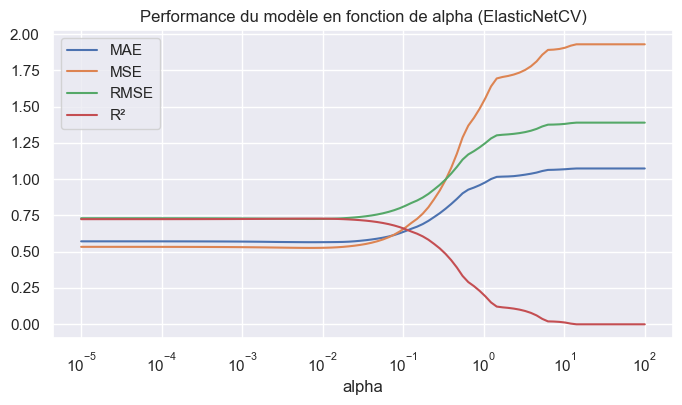

In [37]:
# Initialiser les listes pour stocker les résultats
mae_list = []
rmse_list = []
r2_list = []
mse_list = []

for alpha in alphas:
    # Initialiser le modèle LassoCV avec alphas donné
    Elastic = ElasticNetCV(alphas=[alpha])

    # Entraîner le modèle sur les données d'entraînement
    Elastic.fit(ElasticNet_pipe.named_steps['targetencoder'].transform(X_train), y_train)

    # Prédire sur les données de validation
    y_pred = Elastic.predict(ElasticNet_pipe.named_steps['targetencoder'].transform(X_test))

    mae_list.append(np.mean(np.abs(y_test - y_pred)))
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2_list.append(r2_score(y_test, y_pred))
    mse_list.append(mean_squared_error(y_test, y_pred))
    
# Tracer les résultats pour différentes valeurs d'alpha
sns.set_theme()
plt.figure(figsize=(8, 4))
plt.plot(alphas, mae_list, label='MAE')
plt.plot(alphas, mse_list, label='MSE')
plt.plot(alphas, rmse_list, label='RMSE')
plt.plot(alphas, r2_list, label='R²')
plt.xscale('log')
plt.xlabel('alpha')
plt.title("Performance du modèle en fonction de alpha (ElasticNetCV)")
plt.legend()
plt.show()


In [38]:
# Appliquer la transformation inverse à y_test et y_pred
y_test_unité_origine = np.exp(y_test) - 1
y_pred_unité_origine = np.exp(y_pred) - 1

# Évaluation
print('*'*33)
print("RMSE dans l'unité de base (tCO2e)")
print('*'*33)
print("RMSE = {:.2f}".format(np.sqrt(mean_squared_error(y_test_unité_origine, y_pred_unité_origine))))
print('*'*33)

*********************************
RMSE dans l'unité de base (tCO2e)
*********************************
RMSE = 805.11
*********************************


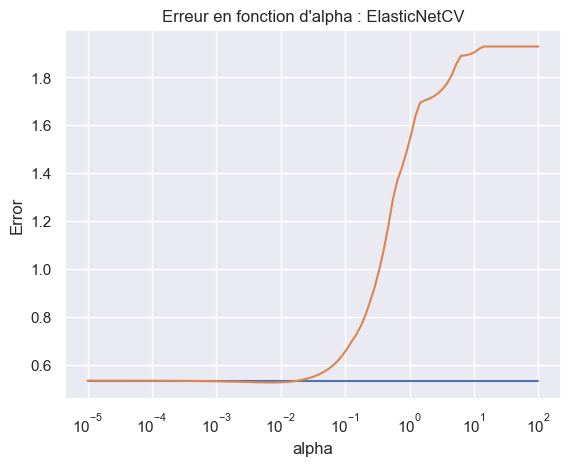

In [39]:
# Erreur en fonction d'alpha
errors = []
for alpha in alphas:
    ElasticNet_pipe.set_params(elasticnetcv__alphas=[alpha])
    ElasticNet_pipe.fit(X_train, y_train)
    y_pred = ElasticNet_pipe.predict(X_test)
    errors.append([baseline_error, np.mean((ElasticNet_pipe.predict(X_test) - y_test) ** 2)])

# Tracer les résultats pour différentes valeurs d'alpha
sns.set_theme()
plt.plot(alphas, errors)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Error')
plt.title("Erreur en fonction d'alpha : ElasticNetCV")
plt.show()

In [40]:
min(errors)

[0.5326929198948919, 0.5252580585553251]

### RandomForestRegressor 

In [41]:
# récupérer les paramètres de RandomForestRegressor()
RandomForestRegressor().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [42]:
# Définir les hyperparamètres à tester
param_dist = {
    'randomforestregressor__n_estimators': np.arange(100, 1000, 100), 
    'randomforestregressor__max_depth': [None, 5, 10, 20], 
    'randomforestregressor__max_features': ['auto', 'sqrt'],
    'randomforestregressor__min_samples_split': [2, 5, 10], 
    'randomforestregressor__min_samples_leaf': [1, 2, 4], 
    'randomforestregressor__bootstrap': [True, False] 
} 
# randomforestregressor__" préfixe utilisé pour indiquer que l'hyperparamètre est appliqué dans le pipeline.

# Créer un pipeline qui applique TargetEncoder et RandomForestRegressor
RFR = make_pipeline(
    TargetEncoder(cols=['LargestPropertyUseType']),
    RandomForestRegressor(random_state=0))

# Effectuer la recherche d'hyperparamètres avec RandomizedSearchCV
Random_Forest_Regressor = RandomizedSearchCV(
    estimator=RFR, 
    param_distributions=param_dist,
    cv=5) 

# Entraîner le modèle
Random_Forest_Regressor.fit(X_train, y_train)

# prédire sur l'ensemble de test
y_pred = Random_Forest_Regressor.predict(X_test)

# Évaluation
print("MAE = {:.2f}".format(mean_absolute_error(y_test, y_pred)))
print("MSE =", mean_squared_error(y_test, y_pred))
print("RMSE = {:.2f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
print("training_time =", training_time)

# Afficher les meilleurs hyperparamètres
print("*"*25)
print("Meilleurs hyperparamètres")
print("*"*25)
print(Random_Forest_Regressor.best_params_)

MAE = 0.53
MSE = 0.48609336100951406
RMSE = 0.70
training_time = 0.009753942489624023
*************************
Meilleurs hyperparamètres
*************************
{'randomforestregressor__n_estimators': 600, 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__max_depth': None, 'randomforestregressor__bootstrap': True}


In [43]:
# Appliquer la transformation inverse à y_test et y_pred
y_test_unité_origine = np.exp(y_test) - 1
y_pred_unité_origine = np.exp(y_pred) - 1

# Évaluation
print('*'*33)
print("RMSE dans l'unité de base (tCO2e)")
print('*'*33)
print("RMSE = {:.2f}".format(np.sqrt(mean_squared_error(y_test_unité_origine, y_pred_unité_origine))))
print('*'*33)

*********************************
RMSE dans l'unité de base (tCO2e)
*********************************
RMSE = 609.09
*********************************


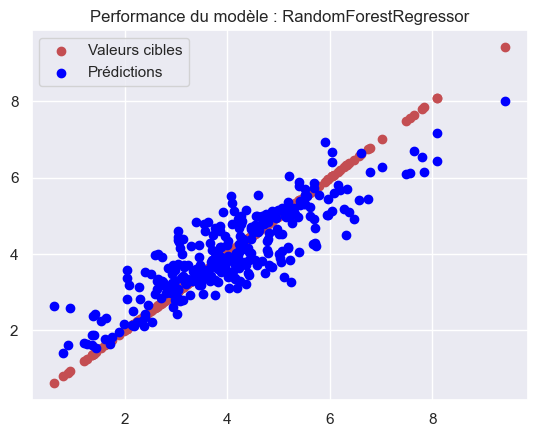

In [44]:
scatter_algo(Random_Forest_Regressor, X_test, y_test, title="Performance du modèle : RandomForestRegressor")

### XGBRegressor

In [45]:
# Définir les hyperparamètres à tester

param_dist = {
    "xgbregressor__n_estimators": np.arange(100, 1000, 100), 
    "xgbregressor__max_depth": np.arange(3, 10),  
    "xgbregressor__learning_rate": np.logspace(-3, 0, 7), 
    "xgbregressor__subsample": np.arange(0.5, 1, 0.1), 
    "xgbregressor__colsample_bytree": np.arange(0.5, 1, 0.1), 
    "xgbregressor__gamma": [0, 0.1, 0.2, 0.3, 0.4],
    "xgbregressor__reg_alpha": [0, 0.1, 0.5, 1, 5, 10], 
    "xgbregressor__reg_lambda": [0, 0.1, 0.5, 1, 5, 10],  
}
# xgbregressor__" préfixe utilisé pour indiquer que l'hyperparamètre est appliqué dans le pipeline.
# Créer un pipeline qui applique TargetEncoder et XGBRegressor
XGBR = make_pipeline(TargetEncoder(cols=['LargestPropertyUseType']), XGBRegressor(random_state=0))

# Effectuer la recherche d'hyperparamètres avec RandomizedSearchCV
XGB_Regressor = RandomizedSearchCV(estimator = XGBR, param_distributions=param_dist,
    cv = 5, n_iter=50, # Nombre de combinaisons aléatoires d'hyperparamètres à essayer
    n_jobs=-1)

# Entraîner le modèle
XGB_Regressor.fit(X_train, y_train)

# prédire sur l'ensemble de test
y_pred = XGB_Regressor.predict(X_test)

# Évaluation
print("MAE = {:.2f}".format(mean_absolute_error(y_test, y_pred)))
print("MSE =", mean_squared_error(y_test, y_pred))
print("RMSE = {:.2f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
print("training_time =", training_time)

# Afficher les meilleurs hyperparamètres
print("*"*25)
print("Meilleurs hyperparamètres ")
print("*"*25)
print(XGB_Regressor.best_params_)
print("*"*25)

MAE = 0.53
MSE = 0.46599860806642823
RMSE = 0.68
training_time = 0.009753942489624023
*************************
Meilleurs hyperparamètres 
*************************
{'xgbregressor__subsample': 0.7999999999999999, 'xgbregressor__reg_lambda': 0, 'xgbregressor__reg_alpha': 1, 'xgbregressor__n_estimators': 700, 'xgbregressor__max_depth': 3, 'xgbregressor__learning_rate': 0.03162277660168379, 'xgbregressor__gamma': 0.2, 'xgbregressor__colsample_bytree': 0.6}
*************************


In [46]:
# Appliquer la transformation inverse à y_test et y_pred
y_test_unité_origine = np.exp(y_test) - 1
y_pred_unité_origine = np.exp(y_pred) - 1

# Évaluation
print('*'*33)
print("RMSE dans l'unité de base (tCO2e)")
print('*'*33)
print("RMSE = {:.2f}".format(np.sqrt(mean_squared_error(y_test_unité_origine, y_pred_unité_origine))))
print('*'*33)

*********************************
RMSE dans l'unité de base (tCO2e)
*********************************
RMSE = 508.55
*********************************


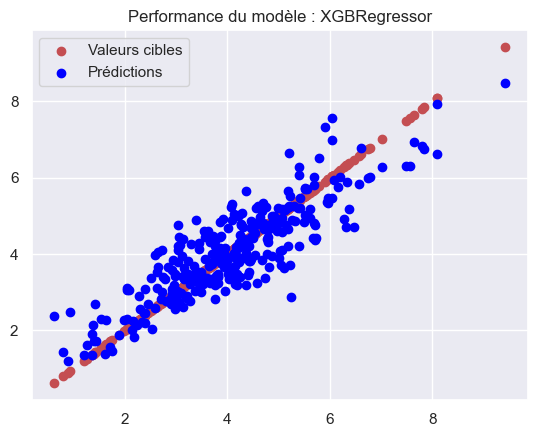

In [47]:
scatter_algo(XGB_Regressor, X_test, y_test, title="Performance du modèle : XGBRegressor")

### Comparaison de modèles par : MSE (minimiser les erreurs), Training Time et Prediction Time

In [60]:
# Initialiser les modèles
models = [LinearRegression(), Ridge(alpha=1.8896), Lasso(alpha=0.0004), 
          ElasticNet(alpha=0.0011, l1_ratio=0.5), 
          RandomForestRegressor(n_estimators=600, min_samples_split=5, 
                                 min_samples_leaf=1, max_features='sqrt', 
                                 max_depth=None, bootstrap=True), 
          XGBRegressor(subsample=0.7999, reg_lambda=0, reg_alpha=1,
                        n_estimators=700, max_depth=3, learning_rate=0.03,
                        gamma= 0.2, colsample_bytree=0.6)]

# initialisation du dictionnaire pour stocker les résultats
results = {'Model': [], 'MSE': [], 'Training Time': [], 'Prediction Time': []} 

# Boucle for pour entraîner et tester chaque modèle
for i, model in enumerate(models):
    start_time = time.time()
    
    # Entraîner le modèle avec X_train_concat
    model.fit(X_train_concat, y_train)
    
    # Prédire les valeurs sur l'ensemble de test
    start_pred_time = time.time()
    y_pred = model.predict(X_test_concat)
    end_pred_time = time.time()
    
    # Stocker les performances du modèle dans le dictionnaire de résultats
    results['Model'].append(str(model).split("(")[0])
    results['MSE'].append(mean_squared_error(y_test, y_pred))
    results['Prediction Time'].append(end_pred_time - start_pred_time)
    results['Training Time'].append(time.time() - start_time)

# Créer un DataFrame pour afficher les résultats
results_df = pd.DataFrame(results)
results_df


,Model,MSE,Training Time,Prediction Time
0,LinearRegression,0.532693,0.010011,0.003371
1,Ridge,0.529857,0.008969,0.003777
2,Lasso,0.531600,0.006039,0.001966
3,ElasticNet,0.530186,0.006686,0.002402
4,RandomForestRegressor,0.496304,1.667003,0.074264
5,XGBRegressor,0.461805,0.697321,0.010078


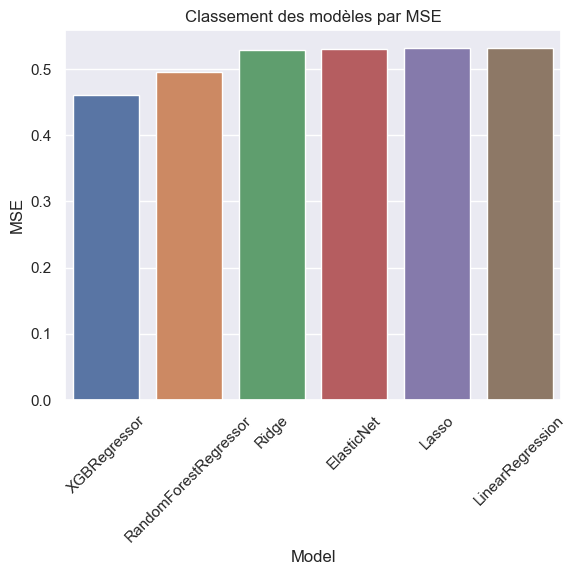

In [61]:
# Classement des modèles par MSE
sns.set_theme()
sns.barplot(data=results_df.sort_values('MSE', ascending=True), x='Model', y='MSE', ci=None)
plt.title("Classement des modèles par MSE", fontname= 'Arial')
plt.ylabel("MSE")
plt.xticks(rotation=45)
plt.xlabel("Model")
plt.show()

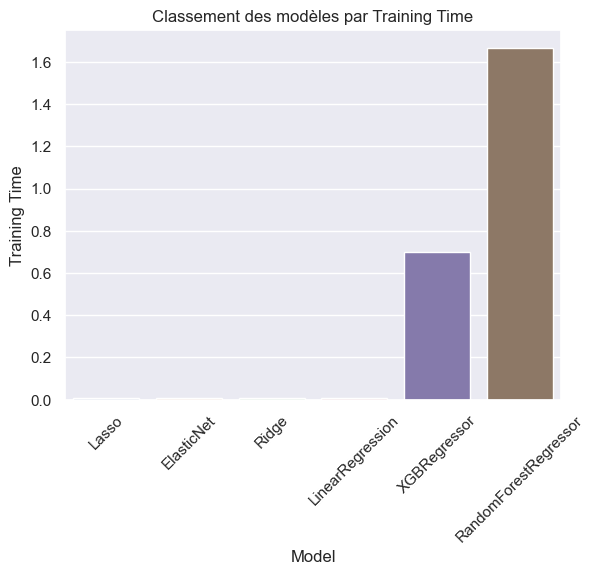

In [62]:
# Classement des modèles par Training Time
sns.set_theme()
sns.barplot(data=results_df.sort_values('Training Time', ascending=True), x='Model', y='Training Time', ci=None)
plt.title("Classement des modèles par Training Time", fontname= 'Arial')
plt.ylabel("Training Time")
plt.xticks(rotation=45)
plt.xlabel("Model")
plt.show()

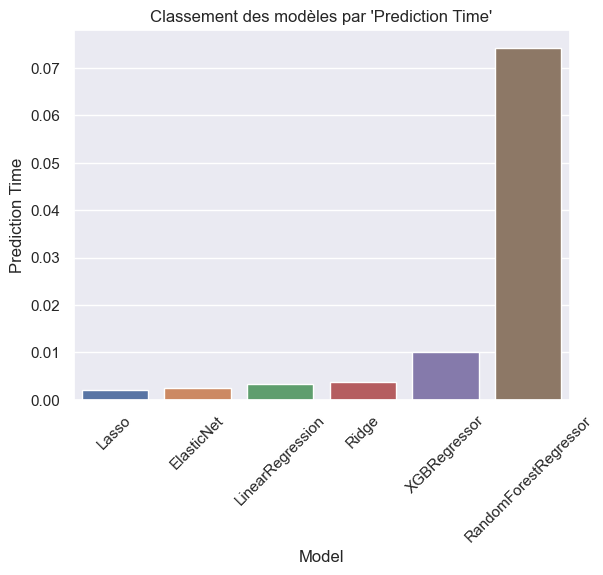

In [63]:
# Classement des modèles par 'Prediction Time'
sns.set_theme()
sns.barplot(data=results_df.sort_values('Prediction Time', ascending=True), x='Model', y='Prediction Time', ci=None)
plt.title("Classement des modèles par 'Prediction Time'", fontname= 'Arial')
plt.ylabel('Prediction Time')
plt.xticks(rotation=45)
plt.xlabel("Model")
plt.show()

### SHAP : modèle LinearRegression

contribution des variables dans le modèle LinearRegression


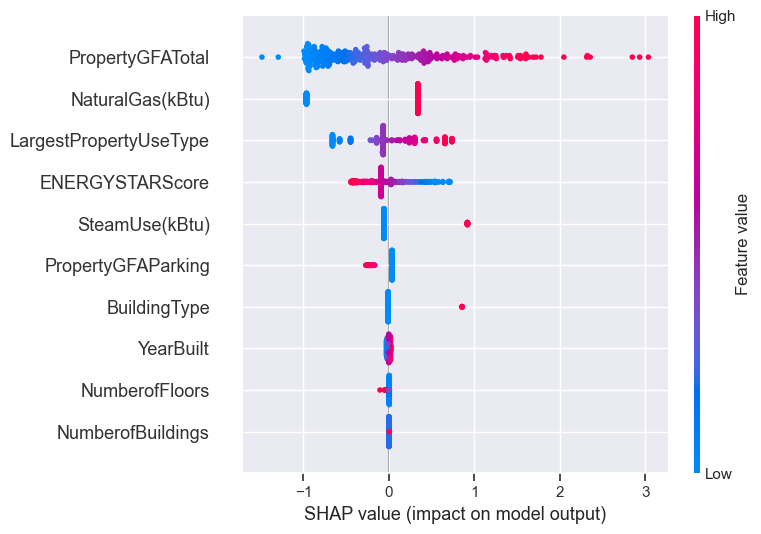

In [52]:
# Calculer les valeurs shap pour chaque variable
explainer = shap.LinearExplainer(Linear_Regression, X_train_concat)
shap_values = explainer.shap_values(X_test_concat)
print("contribution des variables dans le modèle LinearRegression")

# Tracer un graphique de contribution shap global pour chaque variable
shap.summary_plot(shap_values, X_test_concat)

### SHAP : modèle Ridge

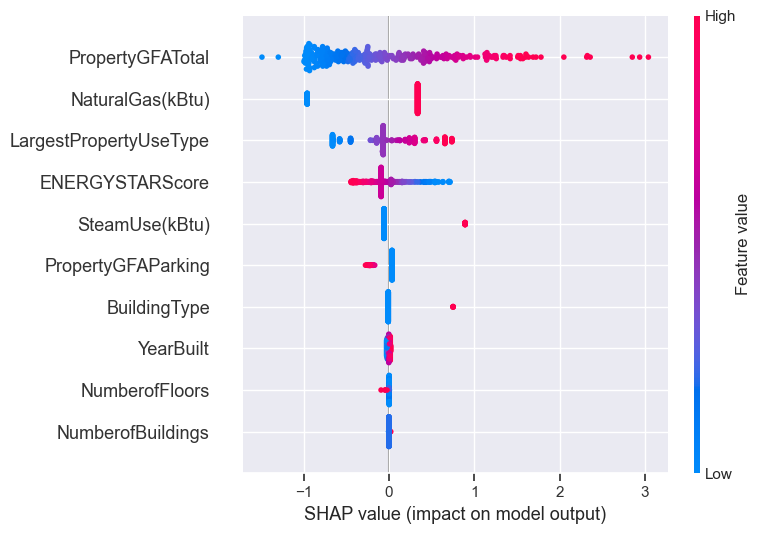

In [53]:
# Initialiser le modèle Ridge avec les meilleurs paramètres
ridge_model = Ridge(alpha=1.8896)

# Entraîner le modèle sur les données d'entraînement
ridge_model.fit(X_train_concat, y_train)

# Calculer les valeurs de SHAP pour le modèle Ridge
explainer = shap.LinearExplainer(ridge_model, X_train_concat)
shap_values = explainer.shap_values(X_test_concat)

# Afficher les valeurs de SHAP pour le modèle Ridge
shap.summary_plot(shap_values, X_test_concat)

### SHAP : modèle Lasso

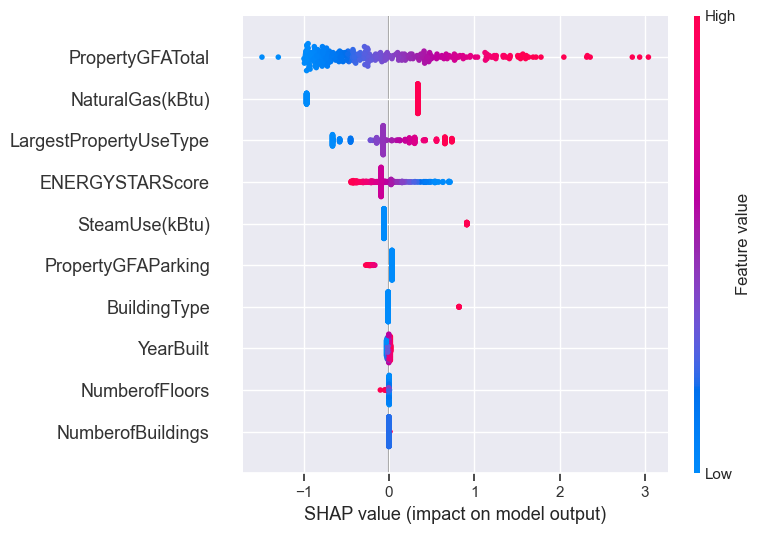

In [54]:
# Initialiser le modèle Lasso avec les meilleurs paramètres
ridge_model = Lasso(alpha=0.0004)

# Entraîner le modèle sur les données d'entraînement
ridge_model.fit(X_train_concat, y_train)

# Calculer les valeurs de SHAP pour le modèle Ridge
explainer = shap.LinearExplainer(ridge_model, X_train_concat)
shap_values = explainer.shap_values(X_test_concat)

# Afficher les valeurs de SHAP pour le modèle Ridge
shap.summary_plot(shap_values, X_test_concat)

### SHAP : modèle ElasticNet

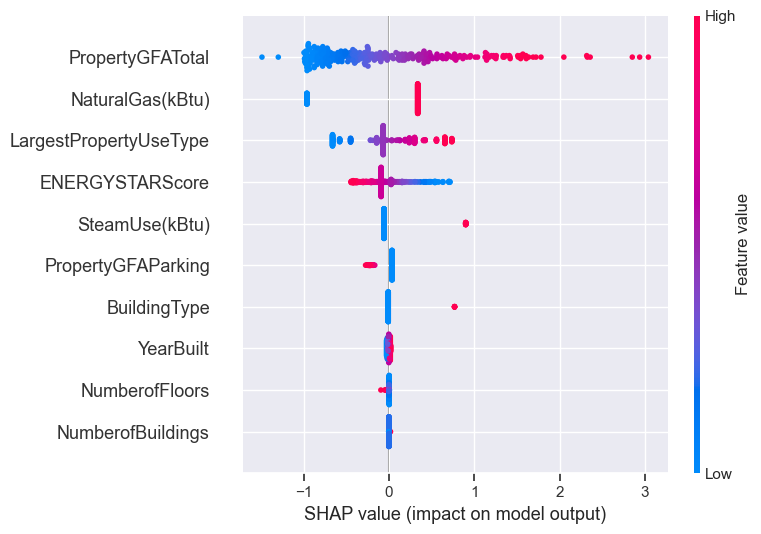

In [55]:
# Initialiser le modèle ElasticNet avec les meilleurs paramètres
elasticnet_model = ElasticNet(alpha=0.0011, l1_ratio=0.5)

# Entraîner le modèle sur les données d'entraînement
elasticnet_model.fit(X_train_concat, y_train)

# Calculer les valeurs de SHAP pour le modèle ElasticNet
explainer = shap.LinearExplainer(elasticnet_model, X_train_concat)
shap_values = explainer.shap_values(X_test_concat)

# Afficher les valeurs de SHAP pour le modèle ElasticNet
shap.summary_plot(shap_values, X_test_concat)


### SHAP : modèle RandomForestRegressor

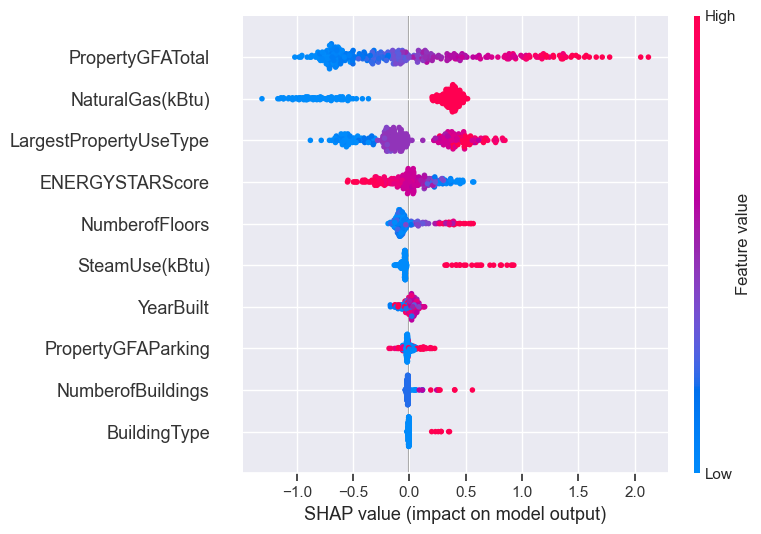

In [64]:
# Initialiser le modèle RandomForestRegressor avec les meilleurs paramètres
rf_model = RandomForestRegressor(n_estimators=600, min_samples_split=5, 
                                 min_samples_leaf=1, max_features='sqrt', 
                                 max_depth=None, bootstrap=True)

# Entraîner le modèle sur les données d'entraînement
rf_model.fit(X_train_concat, y_train)

# Calculer les valeurs de SHAP pour le modèle RandomForestRegressor
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_concat)

# Afficher les valeurs de SHAP pour le modèle RandomForestRegressor
shap.summary_plot(shap_values, X_test_concat)


### SHAP : modèle XGBRegressor

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


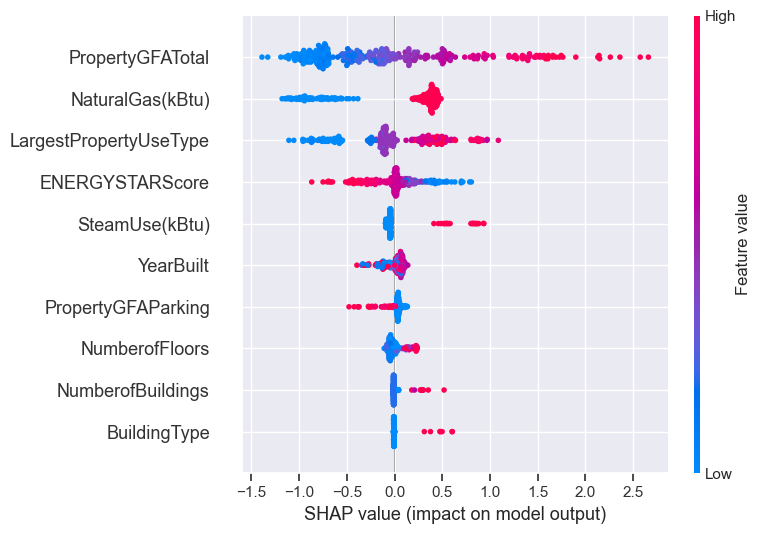

In [65]:
# Initialiser le modèle XGBRegressor avec les meilleurs paramètres
xgb_model =  XGBRegressor(subsample=0.7999, reg_lambda=0, reg_alpha=1,
                        n_estimators=700, max_depth=3, learning_rate=0.03,
                        gamma= 0.2, colsample_bytree=0.6)

# Entraîner le modèle sur les données d'entraînement
xgb_model.fit(X_train_concat, y_train)

# Calculer les valeurs de SHAP pour le modèle XGBRegressor
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_concat)

# Afficher les valeurs de SHAP pour le modèle XGBRegressor
shap.summary_plot(shap_values, X_test_concat)


### Recursive Feature Elimination (RFE)

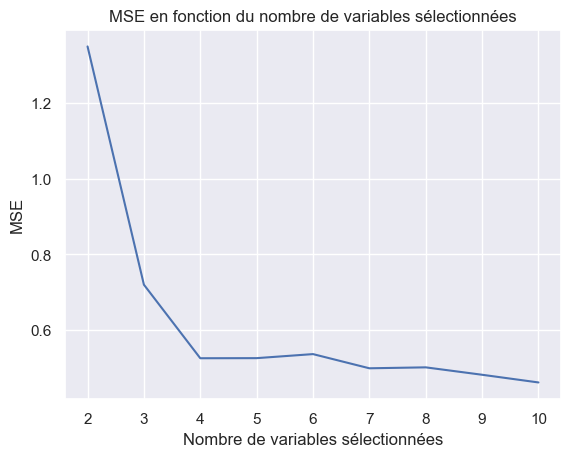

In [66]:

# Définir modèle ridge avec le meilleur alpha 
best_rf_model =  XGBRegressor(subsample=0.7999, reg_lambda=0, reg_alpha=1,
                        n_estimators=700, max_depth=3, learning_rate=0.03,
                        gamma= 0.2, colsample_bytree=0.6)

# Stockage des résultats
mse_scores = []
selected_feature_counts = []

# entraîner le modèle avec différentes n_features_to_select
for n in range(2, len(X_train_concat.columns) + 1):
    rfe = RFE(best_rf_model, n_features_to_select=n)

    # Application de la RFE sur les données d'entraînement
    rfe.fit(X_train_concat, y_train)

    # Utilisation de la méthode support_ pour obtenir les colonnes (fonctionnalités) sélectionnées par la RFE
    selected_features = X_train_concat.columns[rfe.support_]

    # Entraînement du modèle sur les fonctionnalités sélectionnées
    best_rf_model.fit(X_train_concat[selected_features], y_train)

    # Prédiction sur les données de test
    y_pred = best_rf_model.predict(X_test_concat[selected_features])

    # Calcul de l'erreur quadratique moyenne et stockage des résultats
    mse_scores.append(mean_squared_error(y_test, y_pred))
    selected_feature_counts.append(n)

# Tracé de la courbe d'erreur quadratique moyenne en fonction du nombre de variables sélectionnées
plt.plot(selected_feature_counts, mse_scores)
plt.xlabel('Nombre de variables sélectionnées')
plt.ylabel('MSE')
plt.title('MSE en fonction du nombre de variables sélectionnées')
plt.show()


In [69]:
best_rf_model =  XGBRegressor(subsample=0.7999, reg_lambda=0, reg_alpha=1,
                        n_estimators=700, max_depth=3, learning_rate=0.03,
                        gamma= 0.2, colsample_bytree=0.6)

# Création d'une instance de RFE en spécifiant le nombre de variables à conserver
rfe = RFE(best_rf_model, n_features_to_select=4)

# Application de la RFE sur les données d'entraînement
rfe.fit(X_train_concat, y_train)

# Utilisation de la méthode support_ pour obtenir les colonnes (fonctionnalités) sélectionnées par la RFE
selected_features = X_train_concat.columns[rfe.support_]

# Entraînement du modèle sur les fonctionnalités sélectionnées
best_rf_model.fit(X_train_concat[selected_features], y_train)
selected_features.tolist()

['SteamUse(kBtu)',
 'NaturalGas(kBtu)',
 'PropertyGFATotal',
 'LargestPropertyUseType']